In [2]:
import pandas as pd
file_path = '../MONDO_0004975_associations_export.tsv'
df = pd.read_csv(file_path, sep='\t')

# Step 2: Check column names to confirm correct p-value column
print(df.columns)

# Step 3: Filter SNPs with p-value < 1e-8
filtered_df = df[df['pValue'] < 1e-8]

# Step 4: Keep only variantId ending with -A, -T, -C, or -G (exclude -?)
filtered_df = filtered_df[filtered_df['riskAllele'].str.match(r'^rs\d+-[ATCG]$', na=False)]
#convert - to _
filtered_df['riskAllele'] = filtered_df['riskAllele'].str.replace('-', '_')
print(filtered_df['riskAllele'].head())
p_value5_id = filtered_df['riskAllele'].tolist()
# Step 5: Print the first 5 SNPs with p-value < 1e-8
print("SNPs with p-value < 1e-8:")
for snp in p_value5_id:
    print(snp)

Index(['riskAllele', 'pValue', 'pValueAnnotation', 'riskFrequency', 'orValue',
       'beta', 'ci', 'mappedGenes', 'traitName', 'efoTraits', 'bgTraits',
       'accessionId', 'locations', 'pubmedId', 'author'],
      dtype='object')
130    rs143332484_T
131       rs616338_T
133     rs75932628_T
136    rs139967528_G
183       rs593742_A
Name: riskAllele, dtype: object
SNPs with p-value < 1e-8:
rs143332484_T
rs616338_T
rs75932628_T
rs139967528_G
rs593742_A
rs7920721_G
rs138190086_A
rs114812713_C
rs11168036_T
rs283811_G
rs283811_G
rs483082_T
rs6857_T
rs11257238_T
rs41289512_G
rs4663105_C
rs2632516_C
rs9381563_C
rs4236673_A
rs11763230_T
rs7935829_G
rs1859788_A
rs6656401_A
rs6733839_T
rs9331896_C
rs983392_G
rs10792832_A
rs11218343_C
rs4147929_A
rs429358_C
rs429358_C
rs429358_C
rs429358_C
rs2075650_G
rs11754661_A
rs519113_G
rs115550680_G
rs6859_A
rs2373115_G
rs2718058_A
rs11218343_T
rs6656401_A
rs6733839_T
rs10948363_G
rs11771145_G
rs9331896_T
rs983392_A
rs10792832_G
rs4147929_A
rs1476679_T


In [3]:
import pandas as pd
data_with_no_filtering = pd.read_csv('../adni_full.raw', delim_whitespace=True, usecols= lambda x: not x.endswith('.'), nrows=5)

In [4]:
len(data_with_no_filtering.columns)

592538

In [5]:
id_of_pvalue5 = []
for col in data_with_no_filtering.columns:
    if col in p_value5_id:
        print(col, "is in the list")
        id_of_pvalue5.append(col)
print(id_of_pvalue5)


rs6882046_A is in the list
rs2718058_A is in the list
rs11771145_G is in the list
rs10498633_G is in the list
rs8106922_A is in the list
rs5167_T is in the list
['rs6882046_A', 'rs2718058_A', 'rs11771145_G', 'rs10498633_G', 'rs8106922_A', 'rs5167_T']


In [6]:
# read the data again with the selected columns and first 6 columns of data and first 5 rows
metadata_cols = ['IID', 'SEX', 'PHENOTYPE',]

# Combine metadata columns with your filtered SNP rsIDs
columns_to_use = metadata_cols + id_of_pvalue5

# Read only those columns (first 5 + selected SNPs) and first 5 rows
data_with_filtering = pd.read_csv('../adni_full.raw', delim_whitespace=True, usecols=columns_to_use)


In [7]:
#caclulate missing values of every column
missing_values = data_with_filtering.isnull().sum()
# Print the missing values
print("Missing values in each column:")
print(missing_values)
#see the minimum and median and maximum of the data


Missing values in each column:
IID             0
SEX             0
PHENOTYPE       0
rs6882046_A     2
rs2718058_A     1
rs11771145_G    0
rs10498633_G    0
rs8106922_A     0
rs5167_T        0
dtype: int64


In [8]:
# Load ADNIMERGE
adni_merge = pd.read_csv('../ADNIMERGE_11May2025.csv')

# Filter to baseline diagnoses
adni_dx = adni_merge[adni_merge['VISCODE'] == 'bl'][['RID', 'DX']]

# Extract RID from IID if needed (only if IID is like '014_S_0520')
data_with_filtering['RID'] = data_with_filtering['IID'].str.extract(r'_(\d+)$')[0].astype(int)

# Merge DX into your dataset
data_with_filtering = data_with_filtering.merge(adni_dx, on='RID', how='left')

# Drop RID if no longer needed
data_with_filtering.drop(columns=['RID'], inplace=True)

# Check merge result
print("Missing DX labels:", data_with_filtering['DX'].isna().sum())

Missing DX labels: 0


In [9]:
print(data_with_filtering.columns)


Index(['IID', 'SEX', 'PHENOTYPE', 'rs6882046_A', 'rs2718058_A', 'rs11771145_G',
       'rs10498633_G', 'rs8106922_A', 'rs5167_T', 'DX'],
      dtype='object')


In [10]:
columns_to_remove = [ 'IID','SEX','PHENOTYPE']  # Adjust the list based on your data

# Drop the specified columns
data_cleaned_with_just_dx_and_snp = data_with_filtering.drop(columns=columns_to_remove)
#convert data_cleaned_with_just_dx_and_snp to file

In [11]:
# Fill missing values with mode for all columns except 'DX'
for column in data_cleaned_with_just_dx_and_snp.columns:
    if column != 'DX':
        mode_value = data_cleaned_with_just_dx_and_snp[column].mode()[0]
        data_cleaned_with_just_dx_and_snp[column].fillna(mode_value, inplace=True)

In [12]:
# Map DX values to numerical values
dx_mapping = {'CN': 0, 'MCI': 0, 'Dementia': 1}
data_cleaned_with_just_dx_and_snp['DX'] = data_cleaned_with_just_dx_and_snp['DX'].replace(dx_mapping)

In [13]:
print(data_cleaned_with_just_dx_and_snp['DX'].value_counts())

DX
0    577
1    180
Name: count, dtype: int64


In [14]:
#change all float64 columns to int64
for column in data_cleaned_with_just_dx_and_snp.columns:
    if data_cleaned_with_just_dx_and_snp[column].dtype == 'float64':
        data_cleaned_with_just_dx_and_snp[column] = data_cleaned_with_just_dx_and_snp[column].astype('int64')
#save the data_cleaned_with_just_dx_and_snp to a file

In [15]:
# train and test split
from sklearn.model_selection import train_test_split
X = data_cleaned_with_just_dx_and_snp.drop(columns=['DX'])
y = data_cleaned_with_just_dx_and_snp['DX']

In [17]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    matthews_corrcoef, recall_score, roc_auc_score
)

from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    ExtraTreesClassifier, BaggingClassifier, HistGradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# ---------------------
# Assume X and y are defined
# ---------------------

# Define base models
base_models = {
    "Logistic Regression": LogisticRegression(),
    "SVM (Linear)": SVC(kernel="linear", probability=True),
    "SVM (RBF)": SVC(kernel="rbf", probability=True),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    "LightGBM": LGBMClassifier(verbosity=-1),
    "CatBoost": CatBoostClassifier(silent=True),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "HistGradientBoosting": HistGradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "Slow Deeper Neural Net": MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=400, random_state=42),
    "Deep Neural Net": MLPClassifier(hidden_layer_sizes=(200, 100), max_iter=400, random_state=42),
}

# ---------------------
# Evaluation Function
# ---------------------
def evaluate_models(X_train, X_test, y_train, y_test):
    result_rows = []
    for name, model in base_models.items():
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            bal_acc = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='macro')
            mcc = matthews_corrcoef(y_test, y_pred)
            sensitivity = recall_score(y_test, y_pred, average='macro')

            try:
                if hasattr(model, "predict_proba"):
                    y_score = model.predict_proba(X_test)[:, 1]
                else:
                    y_score = model.decision_function(X_test)
                roc_auc = roc_auc_score(y_test, y_score)
            except:
                roc_auc = np.nan

            result_rows.append([name, acc, bal_acc, f1, mcc, sensitivity, roc_auc])

        except Exception as e:
            print(f"Error with model {name}: {e}")

    # Create and display result table
    df = pd.DataFrame(result_rows, columns=[
        "Model", "Accuracy", "BalancedAccuracy", "F1", "MCC", "Sensitivity", "ROC_AUC"
    ])
    df = df.sort_values(by="Accuracy", ascending=False)

    print(df.to_string(index=False, float_format="%.6f"))

# ---------------------
# Loop over random states and test sizes
# ---------------------
for rs in range(1, 162):
    for test_size in np.round(np.arange(0.20, 0.31, 0.01), 2):
        print(f"\n===== Random State: {rs}, Test Size: {test_size} =====")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rs)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        evaluate_models(X_train, X_test, y_train, y_test)



===== Random State: 1, Test Size: 0.2 =====
                 Model  Accuracy  BalancedAccuracy       F1       MCC  Sensitivity  ROC_AUC
      MLP (Neural Net)  0.769737          0.513889 0.461484  0.146079     0.513889 0.579502
   Logistic Regression  0.763158          0.500000 0.432836  0.000000     0.500000 0.544301
          SVM (Linear)  0.763158          0.500000 0.432836  0.000000     0.500000 0.532328
             SVM (RBF)  0.763158          0.500000 0.432836  0.000000     0.500000 0.454741
              AdaBoost  0.763158          0.500000 0.432836  0.000000     0.500000 0.549090
           Naive Bayes  0.763158          0.500000 0.432836  0.000000     0.500000 0.562979
     Gradient Boosting  0.743421          0.496648 0.450246 -0.015982     0.496648 0.586207
              CatBoost  0.723684          0.493295 0.462083 -0.022997     0.493295 0.594109
         Random Forest  0.717105          0.498563 0.476911 -0.004368     0.498563 0.570402
              LightGBM  0.717105   

In [21]:
# ---------------------
# Import Libraries
# ---------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, recall_score, matthews_corrcoef, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
import numpy as np

# ---------------------
# Prepare Dataset
# ---------------------
# Assume X_train, X_test, y_train, y_test are already defined (feature and target datasets)
# Example:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=141)

# ---------------------
# Define Models
# ---------------------
base_models = {
    "Logistic Regression": LogisticRegression(),
    "SVM (Linear)": SVC(kernel="linear"),
    "SVM (RBF)": SVC(kernel="rbf"),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
     "Bagging (RF Base)": BaggingClassifier(),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(silent=True),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "HistGradientBoosting": HistGradientBoostingClassifier(),
    "Neural Network (Basic)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

# Define DNN Model
# def create_dnn_model(input_dim):
#     model = Sequential([
#         Dense(64, input_dim=input_dim, activation='relu'),
#         Dense(32, activation='relu'),
#         Dense(1, activation='sigmoid')  # Sigmoid for binary classification
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# ---------------------
# Evaluation Function
# ---------------------
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n\n=== Evaluating: {name} ===")
    
    model.fit(X_train, y_train)
    
    # For DNN, predict probabilities and convert to binary predictions
    # if name.startswith("Deep Neural Network"):
    #     y_pred_prob = model.predict(X_test)  # This gives probabilities
    #     y_pred = (y_pred_prob >= 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)
    # else:
    y_pred = model.predict(X_test)
    
    print(f"Accuracy:            {accuracy_score(y_test, y_pred):.4f}")
    print(f"Balanced Accuracy:   {balanced_accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 Score (macro):    {f1_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Recall (macro):      {recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Sensitivity (Recall):{recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"MCC:                 {matthews_corrcoef(y_test, y_pred):.4f}")

    try:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]  # Get the probability for class 1
        else:
            y_score = model.decision_function(X_test)
        
        roc_auc = roc_auc_score(y_test, y_score)
        print(f"ROC AUC Score:       {roc_auc:.4f}")
    except Exception as e:
        print(f"ROC AUC Score:       Not available ({e})")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))


# ---------------------
# Run Models
# ---------------------
for name, model in base_models.items():
    print(f"\n=== Running: {name} ===")
    
    # if name.startswith("Deep Neural Network"):
    #     # For deep learning models, directly evaluate after training
    #     input_dim = X_train.shape[1]
    #     model = create_dnn_model(input_dim)
    #     evaluate_model(name, model, X_train, y_train, X_test, y_test)
    # else:
        # Evaluate other models
    evaluate_model(name, model, X_train, y_train, X_test, y_test)



=== Running: Logistic Regression ===


=== Evaluating: Logistic Regression ===
Accuracy:            0.8613
Balanced Accuracy:   0.5000
F1 Score (macro):    0.4627
Recall (macro):      0.5000
Sensitivity (Recall):0.5000
MCC:                 0.0000
ROC AUC Score:       0.5549
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       118
           1       0.00      0.00      0.00        19

    accuracy                           0.86       137
   macro avg       0.43      0.50      0.46       137
weighted avg       0.74      0.86      0.80       137


=== Running: SVM (Linear) ===


=== Evaluating: SVM (Linear) ===
Accuracy:            0.8613
Balanced Accuracy:   0.5000
F1 Score (macro):    0.4627
Recall (macro):      0.5000
Sensitivity (Recall):0.5000
MCC:                 0.0000
ROC AUC Score:       0.6369
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00 

In [24]:
# ---------------------
# Import Libraries
# ---------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, recall_score, matthews_corrcoef, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
import numpy as np

# ---------------------
# Prepare Dataset
# ---------------------
# Assume X_train, X_test, y_train, y_test are already defined (feature and target datasets)
# Example:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=141)

# ---------------------
# Define Models
# ---------------------
base_models = {
    "Logistic Regression": LogisticRegression(),
    "SVM (Linear)": SVC(kernel="linear"),
    "SVM (RBF)": SVC(kernel="rbf"),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
     "Bagging (RF Base)": BaggingClassifier(),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(silent=True),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "HistGradientBoosting": HistGradientBoostingClassifier(),
    "Neural Network (Basic)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

# Define DNN Model
# def create_dnn_model(input_dim):
#     model = Sequential([
#         Dense(64, input_dim=input_dim, activation='relu'),
#         Dense(32, activation='relu'),
#         Dense(1, activation='sigmoid')  # Sigmoid for binary classification
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# ---------------------
# Evaluation Function
# ---------------------
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n\n=== Evaluating: {name} ===")
    
    model.fit(X_train, y_train)
    
    # For DNN, predict probabilities and convert to binary predictions
    # if name.startswith("Deep Neural Network"):
    #     y_pred_prob = model.predict(X_test)  # This gives probabilities
    #     y_pred = (y_pred_prob >= 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)
    # else:
    y_pred = model.predict(X_test)
    
    print(f"Accuracy:            {accuracy_score(y_test, y_pred):.4f}")
    print(f"Balanced Accuracy:   {balanced_accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 Score (macro):    {f1_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Recall (macro):      {recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Sensitivity (Recall):{recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"MCC:                 {matthews_corrcoef(y_test, y_pred):.4f}")

    try:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]  # Get the probability for class 1
        else:
            y_score = model.decision_function(X_test)
        
        roc_auc = roc_auc_score(y_test, y_score)
        print(f"ROC AUC Score:       {roc_auc:.4f}")
    except Exception as e:
        print(f"ROC AUC Score:       Not available ({e})")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))


# ---------------------
# Run Models
# ---------------------
for name, model in base_models.items():
    print(f"\n=== Running: {name} ===")
    
    # if name.startswith("Deep Neural Network"):
    #     # For deep learning models, directly evaluate after training
    #     input_dim = X_train.shape[1]
    #     model = create_dnn_model(input_dim)
    #     evaluate_model(name, model, X_train, y_train, X_test, y_test)
    # else:
        # Evaluate other models
    evaluate_model(name, model, X_train, y_train, X_test, y_test)



=== Running: Logistic Regression ===


=== Evaluating: Logistic Regression ===
Accuracy:            0.8613
Balanced Accuracy:   0.5000
F1 Score (macro):    0.4627
Recall (macro):      0.5000
Sensitivity (Recall):0.5000
MCC:                 0.0000
ROC AUC Score:       0.5549
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       118
           1       0.00      0.00      0.00        19

    accuracy                           0.86       137
   macro avg       0.43      0.50      0.46       137
weighted avg       0.74      0.86      0.80       137


=== Running: SVM (Linear) ===


=== Evaluating: SVM (Linear) ===
Accuracy:            0.8613
Balanced Accuracy:   0.5000
F1 Score (macro):    0.4627
Recall (macro):      0.5000
Sensitivity (Recall):0.5000
MCC:                 0.0000
ROC AUC Score:       0.6369
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00 


=== Evaluating: Logistic Regression ===
Accuracy:            0.8613
Balanced Accuracy:   0.5000
F1 Score (macro):    0.4627
Recall (Sensitivity):0.5000
ROC AUC Score:       0.5549
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       118
           1       0.00      0.00      0.00        19

    accuracy                           0.86       137
   macro avg       0.43      0.50      0.46       137
weighted avg       0.74      0.86      0.80       137


=== Evaluating: SVM (Linear) ===
Accuracy:            0.8613
Balanced Accuracy:   0.5000
F1 Score (macro):    0.4627
Recall (Sensitivity):0.5000
ROC AUC Score:       0.6369
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       118
           1       0.00      0.00      0.00        19

    accuracy                           0.86       137
   macro avg       0.43      0.50      0.46       137


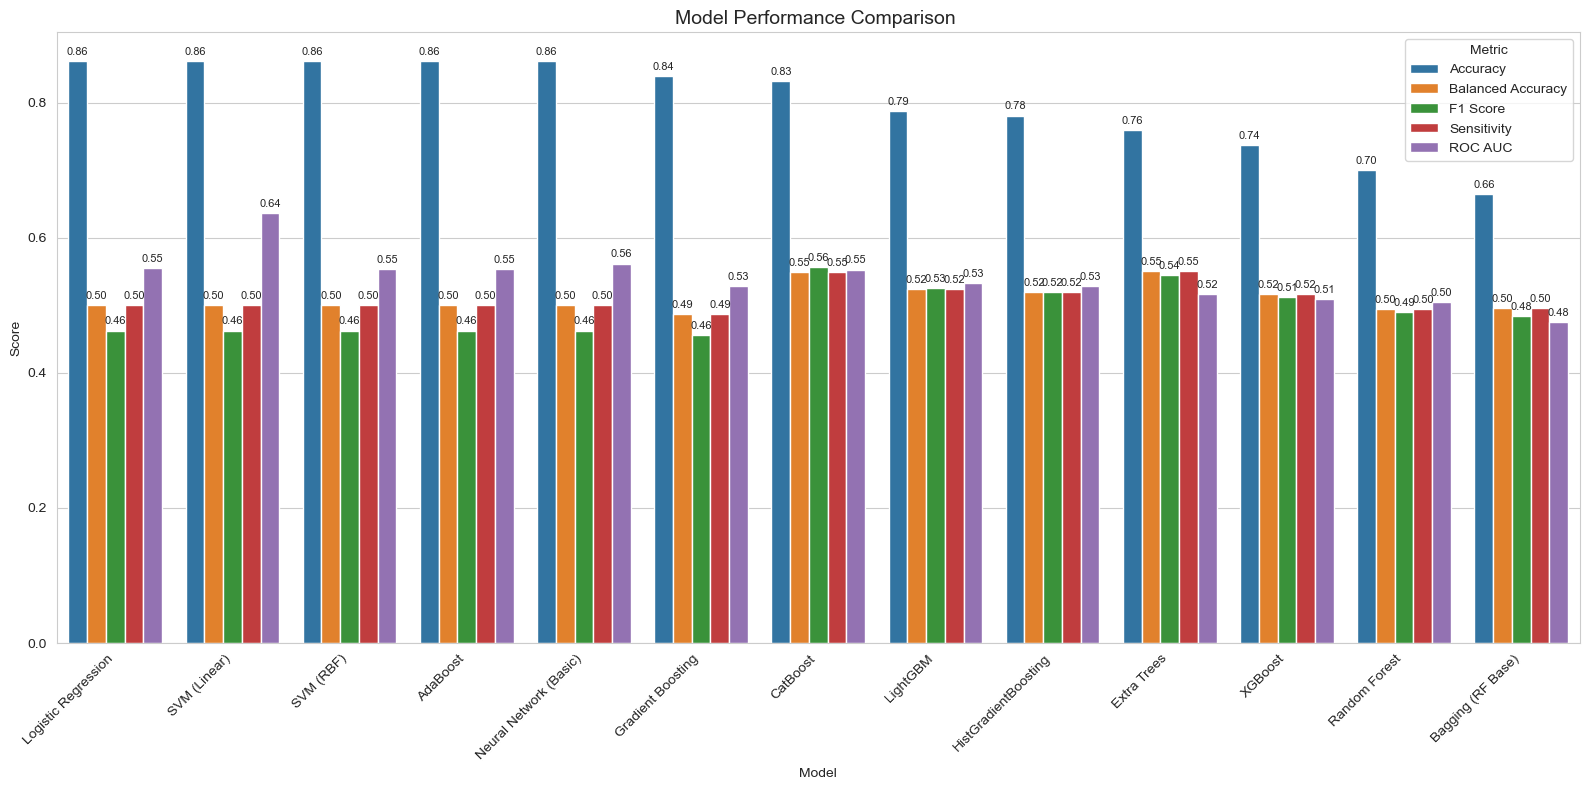

In [27]:
# ---------------------
# Import Libraries
# ---------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    recall_score, roc_auc_score, classification_report
)
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    ExtraTreesClassifier, BaggingClassifier, HistGradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# ---------------------
# Prepare Dataset
# ---------------------
# Assume X and y are defined before this
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=141)

# ---------------------
# Define Models
# ---------------------
base_models = {
    "Logistic Regression": LogisticRegression(),
    "SVM (Linear)": SVC(kernel="linear", probability=True),
    "SVM (RBF)": SVC(kernel="rbf", probability=True),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    "Extra Trees": ExtraTreesClassifier(),
    "Bagging (RF Base)": BaggingClassifier(),
    "LightGBM": LGBMClassifier(verbosity=-1),
    "CatBoost": CatBoostClassifier(silent=True),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "HistGradientBoosting": HistGradientBoostingClassifier(),
    "Neural Network (Basic)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

# ---------------------
# Evaluation Function
# ---------------------
results = []

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    sensitivity = recall_score(y_test, y_pred, average='macro')

    try:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)
        roc_auc = roc_auc_score(y_test, y_score)
    except:
        roc_auc = np.nan

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Balanced Accuracy": bal_acc,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "ROC AUC": roc_auc
    })

    print(f"\n=== Evaluating: {name} ===")
    print(f"Accuracy:            {acc:.4f}")
    print(f"Balanced Accuracy:   {bal_acc:.4f}")
    print(f"F1 Score (macro):    {f1:.4f}")
    print(f"Recall (Sensitivity):{sensitivity:.4f}")
    print(f"ROC AUC Score:       {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))


# ---------------------
# Run and Evaluate Models
# ---------------------
for name, model in base_models.items():
    evaluate_model(name, model, X_train, y_train, X_test, y_test)

# ---------------------
# Plot Results with Value Labels
# ---------------------
df_results = pd.DataFrame(results)
df_results_sorted = df_results.sort_values(by="Accuracy", ascending=False)

# Melt for seaborn
df_melted = df_results_sorted.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")
ax = sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric", palette="tab10")

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3, fontsize=8)

plt.title("Model Performance Comparison ", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.legend(title="Metric")
plt.show()


In [16]:
# ---------------------
# Import Libraries
# ---------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, recall_score, matthews_corrcoef, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
import numpy as np

# ---------------------
# Prepare Dataset
# ---------------------
# Assume X_train, X_test, y_train, y_test are already defined (feature and target datasets)
# Example:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=141)

# ---------------------
# Define Models
# ---------------------
base_models = {
    "Logistic Regression": LogisticRegression(),
    "SVM (Linear)": SVC(kernel="linear"),
    "SVM (RBF)": SVC(kernel="rbf"),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "Extra Trees": ExtraTreesClassifier(n_estimators=150, class_weight='balanced', random_state=42),
     "Bagging (RF Base)": BaggingClassifier(estimator=RandomForestClassifier(n_estimators=100), n_estimators=10, random_state=42),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(silent=True),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "HistGradientBoosting": HistGradientBoostingClassifier(),
    "Neural Network (Basic)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

# Define DNN Model
# def create_dnn_model(input_dim):
#     model = Sequential([
#         Dense(64, input_dim=input_dim, activation='relu'),
#         Dense(32, activation='relu'),
#         Dense(1, activation='sigmoid')  # Sigmoid for binary classification
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# ---------------------
# Evaluation Function
# ---------------------
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n\n=== Evaluating: {name} ===")
    
    model.fit(X_train, y_train)
    
    # For DNN, predict probabilities and convert to binary predictions
    # if name.startswith("Deep Neural Network"):
    #     y_pred_prob = model.predict(X_test)  # This gives probabilities
    #     y_pred = (y_pred_prob >= 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)
    # else:
    y_pred = model.predict(X_test)
    
    print(f"Accuracy:            {accuracy_score(y_test, y_pred):.4f}")
    print(f"Balanced Accuracy:   {balanced_accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 Score (macro):    {f1_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Recall (macro):      {recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Sensitivity (Recall):{recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"MCC:                 {matthews_corrcoef(y_test, y_pred):.4f}")

    try:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]  # Get the probability for class 1
        else:
            y_score = model.decision_function(X_test)
        
        roc_auc = roc_auc_score(y_test, y_score)
        print(f"ROC AUC Score:       {roc_auc:.4f}")
    except Exception as e:
        print(f"ROC AUC Score:       Not available ({e})")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))


# ---------------------
# Run Models
# ---------------------
for name, model in base_models.items():
    print(f"\n=== Running: {name} ===")
    
    # if name.startswith("Deep Neural Network"):
    #     # For deep learning models, directly evaluate after training
    #     input_dim = X_train.shape[1]
    #     model = create_dnn_model(input_dim)
    #     evaluate_model(name, model, X_train, y_train, X_test, y_test)
    # else:
        # Evaluate other models
    evaluate_model(name, model, X_train, y_train, X_test, y_test)



=== Running: Logistic Regression ===


=== Evaluating: Logistic Regression ===
Accuracy:            0.8114
Balanced Accuracy:   0.5000
F1 Score (macro):    0.4479
Recall (macro):      0.5000
Sensitivity (Recall):0.5000
MCC:                 0.0000
ROC AUC Score:       0.5195
Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       185
           1       0.00      0.00      0.00        43

    accuracy                           0.81       228
   macro avg       0.41      0.50      0.45       228
weighted avg       0.66      0.81      0.73       228


=== Running: SVM (Linear) ===


=== Evaluating: SVM (Linear) ===
Accuracy:            0.8114
Balanced Accuracy:   0.5000
F1 Score (macro):    0.4479
Recall (macro):      0.5000
Sensitivity (Recall):0.5000
MCC:                 0.0000
ROC AUC Score:       0.4784
Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00 

c:\Users\Ayoub-Megdoud\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy:            0.8158
Balanced Accuracy:   0.5116
F1 Score (macro):    0.4718
Recall (macro):      0.5116
Sensitivity (Recall):0.5116
MCC:                 0.1377
ROC AUC Score:       0.5187
Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       185
           1       1.00      0.02      0.05        43

    accuracy                           0.82       228
   macro avg       0.91      0.51      0.47       228
weighted avg       0.85      0.82      0.74       228


=== Running: HistGradientBoosting ===


=== Evaluating: HistGradientBoosting ===
Accuracy:            0.7588
Balanced Accuracy:   0.5390
F1 Score (macro):    0.5412
Recall (macro):      0.5390
Sensitivity (Recall):0.5390
MCC:                 0.0929
ROC AUC Score:       0.5952
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.86       185
           1       0.29      0.19      0.23 

c:\Users\Ayoub-Megdoud\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:
# ---------------------
# Import Libraries
# ---------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, recall_score, matthews_corrcoef, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import numpy as np

# ---------------------
# Prepare Dataset
# ---------------------
# Assume X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=141)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---------------------
# Define Models
# ---------------------
base_models = {
    "Logistic Regression": LogisticRegression(),
    "SVM (Linear)": SVC(kernel="linear", probability=True),
    "SVM (RBF)": SVC(kernel="rbf", probability=True),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "Extra Trees": ExtraTreesClassifier(n_estimators=150, class_weight='balanced', random_state=42),
    "Bagging (RF Base)": BaggingClassifier(estimator=RandomForestClassifier(n_estimators=100), n_estimators=10, random_state=42),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(silent=True),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "HistGradientBoosting": HistGradientBoostingClassifier(),
    "Neural Network (Basic)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

# ---------------------
# Evaluation Function
# ---------------------
model_scores = {}

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n\n=== Evaluating: {name} ===")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Accuracy:            {accuracy_score(y_test, y_pred):.4f}")
    print(f"Balanced Accuracy:   {balanced_accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 Score (macro):    {f1_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Recall (macro):      {recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Sensitivity (Recall):{recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"MCC:                 {matthews_corrcoef(y_test, y_pred):.4f}")

    try:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)

        roc_auc = roc_auc_score(y_test, y_score)
        print(f"ROC AUC Score:       {roc_auc:.4f}")
        model_scores[name] = roc_auc
    except Exception as e:
        print(f"ROC AUC Score:       Not available ({e})")
        model_scores[name] = -1  # Flag as unavailable

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

# ---------------------
# Run Models
# ---------------------
for name, model in base_models.items():
    print(f"\n=== Running: {name} ===")
    evaluate_model(name, model, X_train, y_train, X_test, y_test)





=== Running: Logistic Regression ===


=== Evaluating: Logistic Regression ===
Accuracy:            0.8114
Balanced Accuracy:   0.5000
F1 Score (macro):    0.4479
Recall (macro):      0.5000
Sensitivity (Recall):0.5000
MCC:                 0.0000
ROC AUC Score:       0.5197
Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       185
           1       0.00      0.00      0.00        43

    accuracy                           0.81       228
   macro avg       0.41      0.50      0.45       228
weighted avg       0.66      0.81      0.73       228


=== Running: SVM (Linear) ===


=== Evaluating: SVM (Linear) ===
Accuracy:            0.8114
Balanced Accuracy:   0.5000
F1 Score (macro):    0.4479
Recall (macro):      0.5000
Sensitivity (Recall):0.5000
MCC:                 0.0000
ROC AUC Score:       0.5035
Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00 

c:\Users\Ayoub-Megdoud\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy:            0.8158
Balanced Accuracy:   0.5116
F1 Score (macro):    0.4718
Recall (macro):      0.5116
Sensitivity (Recall):0.5116
MCC:                 0.1377
ROC AUC Score:       0.5187
Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       185
           1       1.00      0.02      0.05        43

    accuracy                           0.82       228
   macro avg       0.91      0.51      0.47       228
weighted avg       0.85      0.82      0.74       228


=== Running: HistGradientBoosting ===


=== Evaluating: HistGradientBoosting ===
Accuracy:            0.7588
Balanced Accuracy:   0.5390
F1 Score (macro):    0.5412
Recall (macro):      0.5390
Sensitivity (Recall):0.5390
MCC:                 0.0929
ROC AUC Score:       0.5952
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.86       185
           1       0.29      0.19      0.23 

c:\Users\Ayoub-Megdoud\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# ---------------------
# Import Libraries
# ---------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, recall_score,
    matthews_corrcoef, classification_report, roc_auc_score, precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import numpy as np

# ---------------------
# Prepare Dataset
# ---------------------
# Assume X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=141)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---------------------
# Define Models
# ---------------------
base_models = {
    "Logistic Regression": LogisticRegression(),
    "SVM (Linear)": SVC(kernel="linear", probability=True),
    "SVM (RBF)": SVC(kernel="rbf", probability=True),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "Extra Trees": ExtraTreesClassifier(n_estimators=150, class_weight='balanced', random_state=42),
    "Bagging (RF Base)": BaggingClassifier(estimator=RandomForestClassifier(n_estimators=100), n_estimators=10, random_state=42),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(silent=True),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "HistGradientBoosting": HistGradientBoostingClassifier(),
    "Neural Network (Basic)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

# ---------------------
# Find Best Threshold Function
# ---------------------
def find_best_threshold(y_true, y_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx]

# ---------------------
# Evaluation Function
# ---------------------
model_scores = {}

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n\n=== Evaluating: {name} ===")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Accuracy:            {accuracy_score(y_test, y_pred):.4f}")
    print(f"Balanced Accuracy:   {balanced_accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 Score (macro):    {f1_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Recall (macro):      {recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Sensitivity (Recall):{recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"MCC:                 {matthews_corrcoef(y_test, y_pred):.4f}")

    try:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)

        roc_auc = roc_auc_score(y_test, y_score)
        best_thresh = find_best_threshold(y_test, y_score)
        print(f"ROC AUC Score:       {roc_auc:.4f}")
        print(f"Best Threshold (F1): {best_thresh:.4f}")
        model_scores[name] = roc_auc
    except Exception as e:
        print(f"ROC AUC Score:       Not available ({e})")
        model_scores[name] = -1

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

# ---------------------
# Run Models
# ---------------------
for name, model in base_models.items():
    print(f"\n=== Running: {name} ===")
    evaluate_model(name, model, X_train, y_train, X_test, y_test)

# ---------------------
# Show Top 3 Models by ROC AUC
# ---------------------




=== Running: Logistic Regression ===


=== Evaluating: Logistic Regression ===
Accuracy:            0.8114
Balanced Accuracy:   0.5000
F1 Score (macro):    0.4479
Recall (macro):      0.5000
Sensitivity (Recall):0.5000
MCC:                 0.0000
ROC AUC Score:       0.5197
Best Threshold (F1): 0.1206
Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       185
           1       0.00      0.00      0.00        43

    accuracy                           0.81       228
   macro avg       0.41      0.50      0.45       228
weighted avg       0.66      0.81      0.73       228


=== Running: SVM (Linear) ===


=== Evaluating: SVM (Linear) ===
Accuracy:            0.8114
Balanced Accuracy:   0.5000
F1 Score (macro):    0.4479
Recall (macro):      0.5000
Sensitivity (Recall):0.5000
MCC:                 0.0000
ROC AUC Score:       0.5035
Best Threshold (F1): 0.2343
Classification Report:
              precision    recall

c:\Users\Ayoub-Megdoud\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy:            0.7588
Balanced Accuracy:   0.5390
F1 Score (macro):    0.5412
Recall (macro):      0.5390
Sensitivity (Recall):0.5390
MCC:                 0.0929
ROC AUC Score:       0.5952
Best Threshold (F1): 0.2211
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.86       185
           1       0.29      0.19      0.23        43

    accuracy                           0.76       228
   macro avg       0.56      0.54      0.54       228
weighted avg       0.72      0.76      0.74       228


=== Running: Neural Network (Basic) ===


=== Evaluating: Neural Network (Basic) ===
Accuracy:            0.7939
Balanced Accuracy:   0.5160
F1 Score (macro):    0.4983
Recall (macro):      0.5160
Sensitivity (Recall):0.5160
MCC:                 0.0610
ROC AUC Score:       0.5823
Best Threshold (F1): 0.1808
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96     

c:\Users\Ayoub-Megdoud\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Original distribution: Counter({0: 577, 1: 180})
Resampled distribution: Counter({0: 577, 1: 577})
Train distribution: Counter({1: 462, 0: 461})
Test distribution: Counter({0: 116, 1: 115})

=== Running: Logistic Regression ===
Best Parameters: {'clf__C': 0.1}


=== Evaluating: Logistic Regression ===
Accuracy:            0.5325
Balanced Accuracy:   0.5344
F1 Score:            0.6766
Recall (Sensitivity):0.9826
MCC:                 0.1550
ROC AUC Score:       0.6199
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.09      0.16       116
           1       0.52      0.98      0.68       115

    accuracy                           0.53       231
   macro avg       0.67      0.53      0.42       231
weighted avg       0.68      0.53      0.42       231


=== Running: SVM (Linear) ===


=== Evaluating: SVM (Linear) ===
Accuracy:            0.5931
Balanced Accuracy:   0.5943
F1 Score:            0.6824
Recall (Sensitivity):0.8783
M

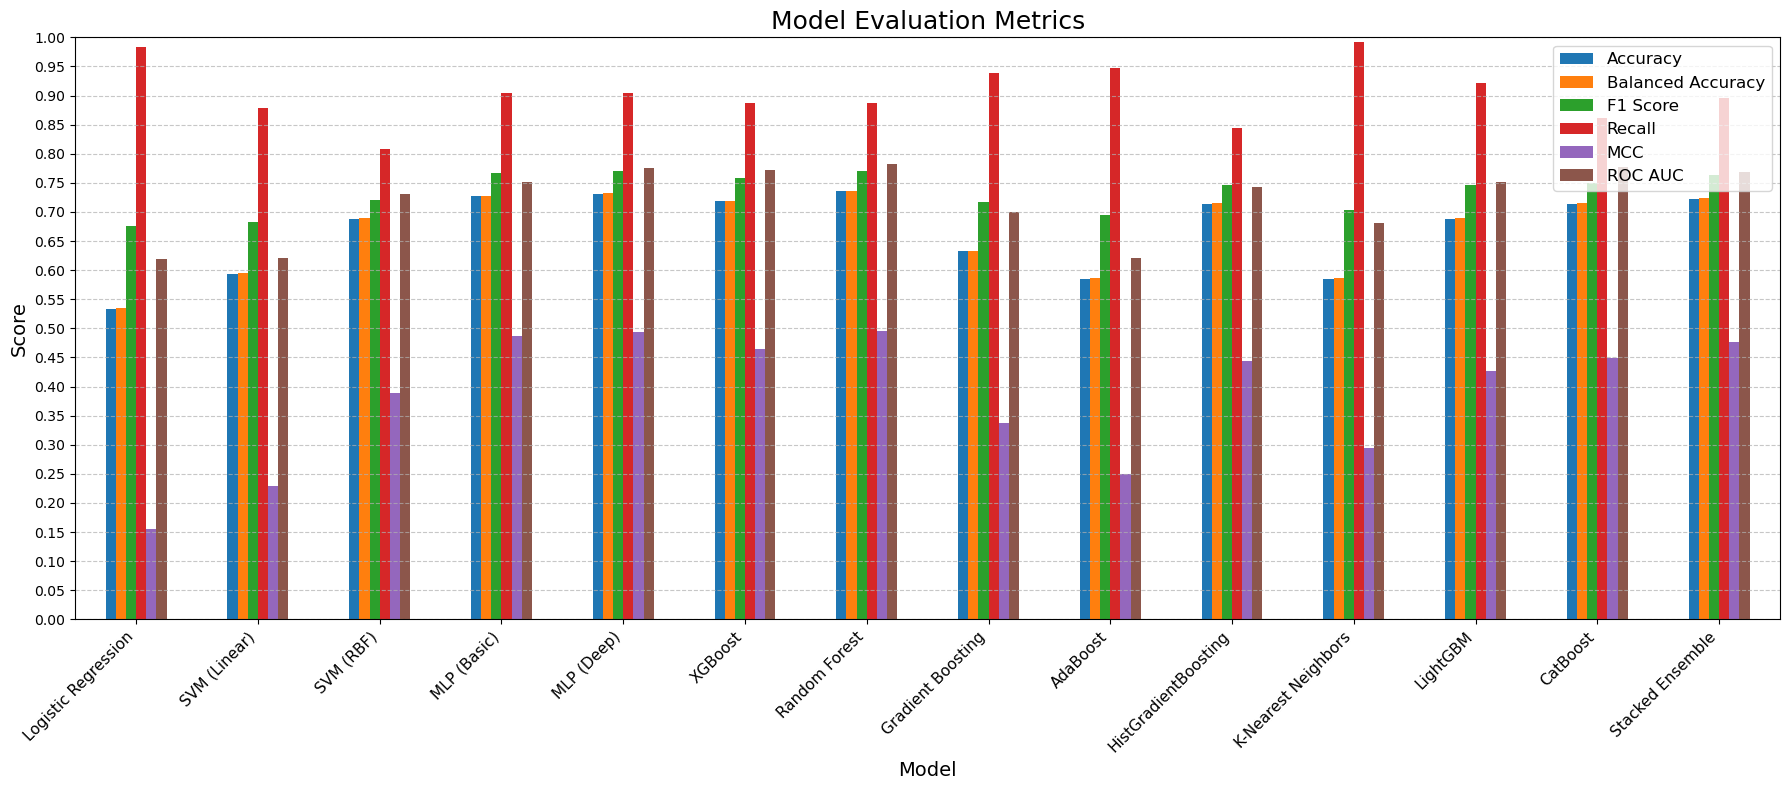

In [20]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from collections import Counter

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, recall_score,
    matthews_corrcoef, roc_auc_score, classification_report, precision_recall_curve
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    HistGradientBoostingClassifier, StackingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Imbalanced-learn
from imblearn.combine import SMOTEENN
# import smote
from imblearn.over_sampling import SMOTE
# Boosting libs
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# ---------------------
# Helper: Best threshold
# ---------------------
def find_best_threshold(y_true, y_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx]

# ---------------------
# Evaluation Function
# ---------------------
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n\n=== Evaluating: {name} ===")
    
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    threshold = find_best_threshold(y_test, y_proba)
    y_pred = (y_proba >= threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"Accuracy:            {acc:.4f}")
    print(f"Balanced Accuracy:   {bacc:.4f}")
    print(f"F1 Score:            {f1:.4f}")
    print(f"Recall (Sensitivity):{recall:.4f}")
    print(f"MCC:                 {mcc:.4f}")
    print(f"ROC AUC Score:       {auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    return {
        "Accuracy": acc,
        "Balanced Accuracy": bacc,
        "F1 Score": f1,
        "Recall": recall,
        "MCC": mcc,
        "ROC AUC": auc
    }

# ---------------------
# Load your SNP dataset
# ---------------------
X = data_cleaned_with_just_dx_and_snp.drop(columns=['DX']).values
y = data_cleaned_with_just_dx_and_snp['DX'].values

# ---------------------
# Data Augmentation BEFORE Split
# ---------------------
sampler = SMOTE(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X, y)

print("Original distribution:", Counter(y))
print("Resampled distribution:", Counter(y_resampled))

# ---------------------
# Train/Test Split
# ---------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

print("Train distribution:", Counter(y_train))
print("Test distribution:", Counter(y_test))

# ---------------------
# Models + Pipelines
# ---------------------
base_models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', max_iter=1000),
    "SVM (Linear)": SVC(kernel='linear', probability=True, class_weight='balanced'),
    "SVM (RBF)": SVC(kernel='rbf', probability=True, class_weight='balanced'),
    "MLP (Basic)": MLPClassifier(hidden_layer_sizes=(64,), alpha=0.0001, max_iter=1000),
    "MLP (Deep)": MLPClassifier(hidden_layer_sizes=(128, 64, 32), alpha=0.0005, learning_rate_init=0.001, max_iter=1500),
    "XGBoost": XGBClassifier(scale_pos_weight=1, eval_metric='logloss', use_label_encoder=False),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "HistGradientBoosting": HistGradientBoostingClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "LightGBM": LGBMClassifier(class_weight='balanced', verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0, auto_class_weights='Balanced'),
    "Stacked Ensemble": StackingClassifier(
        estimators=[
            ('xgb', XGBClassifier(eval_metric='logloss', use_label_encoder=False)),
            ('mlp', MLPClassifier(max_iter=1000))
        ],
        final_estimator=LogisticRegression()
    )
}

# Optional: Basic tuning for some models
param_grid = {
    "Logistic Regression": {'clf__C': [0.1, 1, 10]},
    "SVM (RBF)": {'clf__C': [0.1, 1, 10], 'clf__gamma': ['scale', 'auto']},
    "Random Forest": {'clf__n_estimators': [100, 200], 'clf__max_depth': [None, 10, 20]},
}

# ---------------------
# Run all models and store metrics
# ---------------------
results = {}

for name, model in base_models.items():
    print(f"\n=== Running: {name} ===")
    
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    
    if name in param_grid:
        grid = GridSearchCV(pipe, param_grid[name], cv=5, scoring='f1', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print("Best Parameters:", grid.best_params_)
    else:
        best_model = pipe 

    metrics = evaluate_model(name, best_model, X_train, y_train, X_test, y_test)
    results[name] = metrics

# ---------------------
# Plotting metrics
# ---------------------
df_results = pd.DataFrame(results).T

plot_metrics = ["Accuracy", "Balanced Accuracy", "F1 Score", "Recall", "MCC", "ROC AUC"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

fig, ax = plt.subplots(figsize=(18, 8))
df_results[plot_metrics].plot(kind='bar', ax=ax, color=colors)

ax.set_title("Model Evaluation Metrics", fontsize=18)
ax.set_ylabel("Score", fontsize=14)
ax.set_xlabel("Model", fontsize=14)
ax.set_xticklabels(df_results.index, rotation=45, ha="right", fontsize=11)
ax.legend(loc="upper right", fontsize=12)

# Set y-axis ticks and format
ax.set_ylim(0, 1.0)
ax.set_yticks(np.arange(0, 1.01, 0.05))  # Add this line for 0.05 increments
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.2f}'))

ax.grid(True, linestyle='--', axis='y', alpha=0.7)

plt.tight_layout()
plt.show()



In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    HistGradientBoostingClassifier, StackingClassifier
)
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    roc_auc_score, matthews_corrcoef, recall_score
)
from imblearn.combine import SMOTETomek

# Example data (remove if using your own dataset)
# X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5,
#                            weights=[0.7, 0.3], random_state=42)

# 1. Split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=87)

# 2. Apply SMOTETomek on training data
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

# 3. Standardize features
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

# 4. Define your models
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', max_iter=1000),
    "SVM (Linear)": SVC(kernel='linear', probability=True, class_weight='balanced'),
    "SVM (RBF)": SVC(kernel='rbf', probability=True, class_weight='balanced'),
    "MLP (Basic)": MLPClassifier(hidden_layer_sizes=(64,), alpha=0.0001, max_iter=1000),
    "MLP (Deep)": MLPClassifier(hidden_layer_sizes=(128, 64, 32), alpha=0.0005, learning_rate_init=0.001, max_iter=1500),
    "XGBoost": XGBClassifier(scale_pos_weight=1, eval_metric='logloss', use_label_encoder=False),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "HistGradientBoosting": HistGradientBoostingClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Stacked Ensemble": StackingClassifier(
        estimators=[
            ('xgb', XGBClassifier(eval_metric='logloss', use_label_encoder=False)),
            ('mlp', MLPClassifier(max_iter=1000))
        ],
        final_estimator=LogisticRegression()
    )
}

# 5. Train and Evaluate Models
results = []

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "MCC": mcc,
        "Sensitivity": sensitivity,
        "ROC AUC": roc_auc,
        "Balanced Accuracy": bal_acc
    })

# 6. Display Results
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print(results_df) 


                   Model  Accuracy       MCC  Sensitivity   ROC AUC  \
6          Random Forest  0.706140  0.019325     0.129630  0.499628   
2              SVM (RBF)  0.666667 -0.027682     0.148148  0.535760   
11      Stacked Ensemble  0.666667 -0.043182     0.129630  0.505534   
5                XGBoost  0.662281 -0.004858     0.185185  0.498936   
9   HistGradientBoosting  0.649123 -0.051824     0.148148  0.516603   
7      Gradient Boosting  0.640351  0.017660     0.259259  0.522776   
0    Logistic Regression  0.627193  0.036683     0.314815  0.531609   
3            MLP (Basic)  0.627193 -0.024748     0.222222  0.498616   
1           SVM (Linear)  0.622807  0.019334     0.296296  0.538740   
4             MLP (Deep)  0.609649 -0.009020     0.277778  0.542784   
8               AdaBoost  0.600877  0.027158     0.351852  0.514474   
10   K-Nearest Neighbors  0.526316 -0.036291     0.388889  0.472542   

    Balanced Accuracy  
6            0.507344  
2            0.487867  
11  

In [56]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    HistGradientBoostingClassifier, StackingClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    roc_auc_score, matthews_corrcoef, recall_score
)
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

# Generate a synthetic dataset


# Cross-validation evaluation
def evaluate_model_cv(model, X, y):
    kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
    accs, baccs, f1s, mccs, aucs, recalls = [], [], [], [], [], []

    for train_idx, val_idx in kf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('smt', SMOTETomek(random_state=42)),
            ('clf', model)
        ])

        pipeline.fit(X_tr, y_tr)
        y_val_pred = pipeline.predict(X_val)
        y_val_proba = pipeline.predict_proba(X_val)[:, 1]

        accs.append(accuracy_score(y_val, y_val_pred))
        baccs.append(balanced_accuracy_score(y_val, y_val_pred))
        f1s.append(f1_score(y_val, y_val_pred))
        mccs.append(matthews_corrcoef(y_val, y_val_pred))
        recalls.append(recall_score(y_val, y_val_pred))
        aucs.append(roc_auc_score(y_val, y_val_proba))

    return {
        "Accuracy": np.mean(accs),
        "Balanced Accuracy": np.mean(baccs),
        "F1 Score": np.mean(f1s),
        "Recall (Sensitivity)": np.mean(recalls),
        "MCC": np.mean(mccs),
        "ROC AUC": np.mean(aucs)
    }

# Test set evaluation
def evaluate_on_test(model, X_train, y_train, X_test, y_test):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smt', SMOTETomek(random_state=42)),
        ('clf', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    return {
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Test Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
        "Test F1 Score": f1_score(y_test, y_pred),
        "Test Recall": recall_score(y_test, y_pred),
        "Test MCC": matthews_corrcoef(y_test, y_pred),
        "Test ROC AUC": roc_auc_score(y_test, y_proba)
    }

# Define classifiers
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', max_iter=1000),
    "SVM (Linear)": SVC(kernel='linear', probability=True, class_weight='balanced'),
    "SVM (RBF)": SVC(kernel='rbf', probability=True, class_weight='balanced'),
    "MLP (Basic)": MLPClassifier(hidden_layer_sizes=(64,), alpha=0.0001, max_iter=1000),
    "MLP (Deep)": MLPClassifier(hidden_layer_sizes=(128, 64, 32), alpha=0.0005, learning_rate_init=0.001, max_iter=1500),
    "XGBoost": XGBClassifier(scale_pos_weight=1, eval_metric='logloss', use_label_encoder=False),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "HistGradientBoosting": HistGradientBoostingClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "LightGBM": LGBMClassifier(class_weight='balanced', verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0, auto_class_weights='Balanced'),
    "Stacked Ensemble": StackingClassifier(
        estimators=[
            ('xgb', XGBClassifier(eval_metric='logloss', use_label_encoder=False)),
            ('mlp', MLPClassifier(max_iter=1000))
        ],
        final_estimator=LogisticRegression()
    )
}

custom_colors = [
    '#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974',
    '#64B5CD', '#FF7F0E', '#8C564B', '#E377C2', '#7F7F7F',
    '#BCBD22', '#17BECF', '#D62728', '#9467BD'
]

# Multiple random seeds
random_states = [66, 20, 87, 141, 69, 90]
all_results = {}

for seed in random_states:
    print(f"\n📌 Evaluating for random state: {seed}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=y
    )

    results_combined = {}

    for name, model in models.items():
        print(f"→ Evaluating {name}")
        metrics_cv = evaluate_model_cv(model, X_train, y_train)
        metrics_test = evaluate_on_test(model, X_train, y_train, X_test, y_test)
        combined = {**metrics_cv, **metrics_test}
        results_combined[name] = combined

    df_results = pd.DataFrame(results_combined).T
    all_results[seed] = df_results

    print("\n📊 CV + Test Results:")
    print(df_results.round(4))

    # Plotting
    fig, ax = plt.subplots(figsize=(26, 12))
    plot_columns = [
        "Accuracy", "F1 Score", "ROC AUC",
        "Test Accuracy", "Test F1 Score", "Test ROC AUC"
    ]
    df_results[plot_columns].plot(kind='bar', ax=ax, color=custom_colors[:len(plot_columns)])

    ax.set_title(f"Model CV + Test Performance - Random State {seed}", fontsize=20)
    ax.set_ylabel("Score", fontsize=16)
    ax.set_xlabel("Model", fontsize=16)
    ax.set_xticklabels(df_results.index, rotation=45, ha="right", fontsize=13)
    ax.legend(loc="upper right", fontsize=12)

    # ✅ Set y-axis from 0.00 to 1.00 with ticks every 0.05
    custom_yticks = np.arange(0.00, 1.01, 0.05)
    ax.set_yticks(custom_yticks)
    ax.set_ylim(0.00, 1.00)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(axis='y', which='major', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()



📌 Evaluating for random state: 66
→ Evaluating Logistic Regression


KeyError: "None of [Index([  0,   1,   2,   4,   6,   7,   8,   9,  10,  11,\n       ...\n       594, 595, 596, 598, 599, 600, 601, 602, 603, 604],\n      dtype='int64', length=484)] are in the [columns]"